In [1]:
!pip install pyLDAvis

     |████████████████████████████████| 1.6 MB 5.3 MB/s eta 0:00:01
  Created wheel for pyLDAvis: filename=pyLDAvis-2.1.2-py2.py3-none-any.whl size=97711 sha256=1881457c0963a14c4fa2404ca9734524fc8925d829b662a5648c1a721780c344
  Stored in directory: /home/ec2-user/.cache/pip/wheels/57/de/11/0a038be70c2c212ce45fa0f4f9da165bb5dd87de1288394dc3
Successfully built pyLDAvis


In [18]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from src import lda_utils, nlp_topic_utils
from src.process_text_variables import contracted_words_dict, stop_words_dict, punc 

import re
from bs4 import BeautifulSoup

import nltk
from nltk.corpus import stopwords

from datetime import datetime

#nltk.download('wordnet')

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()

# LDA - Wall Street Market

## Import Dataset and LDA Model Inputs

In [7]:
wallstreet = pd.read_csv('data/wallstreet_master.csv')
wallstreet['lemmatized_tokens'] = wallstreet['contentWithHTMLTag'].apply(lambda x: nlp_topic_utils.process_text(x, contracted_words_dict, punc, stop_words_dict, min_len=1))

In [8]:
n_topics = 20
max_doc_freq = 0.7
max_feats = 10000
max_iterations = 25

docs_raw = [' '.join(d) for d in wallstreet['lemmatized_tokens']]

--- 
# Bag of Words

In [9]:
vectorizer = CountVectorizer(max_features=max_feats, max_df=max_doc_freq)
docs_vectorized = vectorizer.fit_transform(docs_raw)

In [11]:
# Must be even for visualizations.

lda_output_bow, lda_model_bow, docs_vectorized_bow, vect_bow = lda_utils.convert_to_bow_and_fit_lda_model(docs_raw, max_feats, max_doc_freq, n_topics, 'batch', max_iterations, 3)

sorted_components = np.argsort(lda_model_bow.components_, axis=1)[:, ::-1]
feat_names = np.array(vect_bow.get_feature_names())

In [12]:
lda_utils.print_topics(lda_model_bow, vect_bow, 10)


Topic #0:
card know need wrote buy make like good carding work

Topic #1:
credit fullz bank visa shop state picsou usa debit fresh

Topic #2:
gold may mg drug year world law pdf without case

Topic #3:
method profile money offer btc guide onion cashout need paypal

Topic #4:
order dispute support vendor wallet ticket address btc refund escrow

Topic #5:
bump market order utopia store wsm refund reship kush gramo

Topic #6:
use mirror using onionshop tor file rdp vpn ip tail

Topic #7:
contact allowed external read link rule jabber deal marketplace forum

Topic #8:
card address name number phone cc information info use interested

Topic #9:
drug consider ice arab sand nun smashed testicle eskimo like

Topic #10:
note quality bill good passport high fake license see thanks

Topic #11:
day log chat room bank fraud one cashout change everythingcc

Topic #12:
quality sample product high gram best price top pill time

Topic #13:
pgp message key signature begin end signed public hash vendor


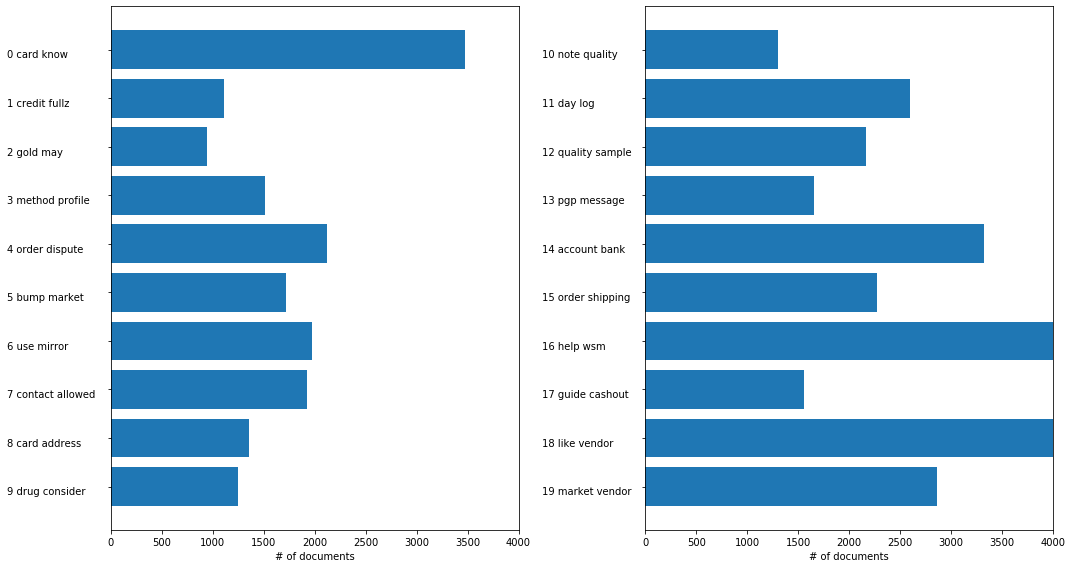

In [13]:
# Evaluate each topics (components) overall weight.
# Topics are named by the two most common words.

topics_per_plot = int(n_topics / 2)
barh_xlim = 4000
plot_pad = 100
fig_size = (15,8)
num_cols = 2

fig, ax = plt.subplots(1, 2, figsize=fig_size)

topic_names = ['{} {}'.format(i, ' '.join(words)) for i, words in enumerate(feat_names[sorted_components[:, :2]])]

for col in range(num_cols):
    start = col * topics_per_plot
    end = (col + 1) * topics_per_plot
    plot_width = np.sum(lda_output_bow, axis=0)[start:end]
    ax[col].barh(np.arange(topics_per_plot), plot_width)
    ax[col].set_yticks(np.arange(topics_per_plot))
    ax[col].set_yticklabels(topic_names[start:end], ha='left', va='top')
    ax[col].invert_yaxis()
    ax[col].set_xlim(0, barh_xlim)
    ax[col].set_xlabel('# of documents')
    y_ax = ax[col].get_yaxis()
    y_ax.set_tick_params(pad=plot_pad)

plt.tight_layout();

In [ ]:
# Topic order is based on topic popularity.
# The distance b/t circles reprsents an approximation topic similarity. It's approximation b/c only a 2D map.
# When lambda = 0, the bar chart solely show topic-specific terms (jargon).
doc_term_matrix = np.matrix(lda_model_bow.components_)
pyLDAvis.sklearn.prepare(lda_model_bow, doc_term_matrix, vect_bow)

### Model Performance

In [ ]:
# Log Likelihood: Higher the better
print('Log Likelihood: ', lda_model_bow.score(docs_vectorized_bow))

# Perplexity: Lower the better. Perplexity = exp(-1. * log-likelihood per word)
print('Perplexity: ', lda_model_bow.perplexity(docs_vectorized_bow))

# Model parameters
print(lda_model_bow.get_params())

---
# TF-IDF

In [ ]:
lda_output_tfidf, lda_model_tfidf, docs_vectorized_tfidf, vect_tfidf = lda_utils.calculate_tfidf_and_fit_lda_model(docs_raw, max_features, max_doc_freq, 
                                                                                                                   n_topics, 'batch', max_iterations, 3)

sorted_components = np.argsort(lda_model_tfidf.components_, axis=1)[:, ::-1]
feat_names = np.array(vect_tfidf.get_feature_names())

In [ ]:
lda_utils.print_topics(lda_model_tfidf, vect_tfidf, 10)

In [ ]:
doc_term_matrix = np.matrix(lda_model_tfidf.components_)
pyLDAvis.sklearn.prepare(lda_model_tfidf, doc_term_matrix, vect_tfidf)

In [ ]:
# Log Likelihood: Higher the better
print('Log Likelihood: ', round(lda_model_tfidf.score(docs_vectorized_tfidf), 2))

# Perplexity: Lower the better. Perplexity = exp(-1. * log-likelihood per word)
print('Perplexity: ', round(lda_model_tfidf.perplexity(docs_vectorized_tfidf), 2))

# Model parameters
print(lda_model_tfidf.get_params())

---
## Design for Web App

In [ ]:
for col in range(num_cols):
    start = col * topics_per_plot
    end = (col + 1) * topics_per_plot
    plot_width = np.sum(lda_output_bow, axis=0)[start:end]
    ax[col].barh(np.arange(topics_per_plot), plot_width)
    ax[col].set_yticks(np.arange(topics_per_plot))
    ax[col].set_yticklabels(topic_names[start:end], ha='left', va='top')
    ax[col].invert_yaxis()
    ax[col].set_xlim(0, barh_xlim)
    ax[col].set_xlabel('# of documents')
    y_ax = ax[col].get_yaxis()
    y_ax.set_tick_params(pad=plot_pad)

plt.tight_layout();

In [33]:
#def plot_components_freq()


sorted_components = np.argsort(lda_model_bow.components_, axis=1)[:, ::-1]
feat_names = np.array(vect_bow.get_feature_names())

n_words_per_component = 2
model_output = lda_output_bow

topics_per_plot = int(n_topics / 2)
num_docs_per_topic = np.sum(model_output, axis=0)
barh_xlim = np.max(num_docs_per_topic) * 0.1
y_arr = np.arange(topics_per_plot)

topic_names = ['{} {}'.format(i+1, ' '.join(words)) for i, words in enumerate(feat_names[sorted_components[:, :n_words_per_component]])]

fig = make_subplots(rows=1, cols=2, horizontal_spacing=0.15)
fig.update_layout(showlegend=False, width=1000, height=800)

# Plot 1
n_docs_plot_1 = num_docs_per_topic[:topics_per_plot]

fig.add_trace(go.Bar(x=n_docs_plot_1[::-1], y=topic_names[:topics_per_plot][::-1], orientation='h'), row=1, col=1)
fig.update_xaxes(title_text="# of Documents", row=1, col=1)

# Plot 2
n_docs_plot_2 = num_docs_per_topic[topics_per_plot:]

fig.add_trace(go.Bar(x=n_docs_plot_2[::-1], y=topic_names[topics_per_plot:][::-1], orientation='h'), row=1, col=2)
fig.update_xaxes(title_text="# of Documents", row=1, col=2)


fig.show();

In [ ]:
def plot_lda_components_distribution(model, vectorizer, model_output, n_topics,)

sorted_components = np.argsort(model.components_, axis=1)[:, ::-1]
feat_names = np.array(vectorizer.get_feature_names())

n_words_per_component = 2
model_output = lda_output_bow

topics_per_plot = int(n_topics / 2)
num_docs_per_topic = np.sum(model_output, axis=0)
barh_xlim = np.max(num_docs_per_topic) * 0.1
y_arr = np.arange(topics_per_plot)

topic_names = ['{} {}'.format(i+1, ' '.join(words)) for i, words in enumerate(feat_names[sorted_components[:, :n_words_per_component]])]

fig = make_subplots(rows=1, cols=2, horizontal_spacing=0.15)
fig.update_layout(showlegend=False, width=1000, height=800)

# Plot 1
n_docs_plot_1 = num_docs_per_topic[:topics_per_plot]

fig.add_trace(go.Bar(x=n_docs_plot_1[::-1], y=topic_names[:topics_per_plot][::-1], orientation='h'), row=1, col=1)
fig.update_xaxes(title_text="# of Documents", row=1, col=1)

# Plot 2
n_docs_plot_2 = num_docs_per_topic[topics_per_plot:]

fig.add_trace(go.Bar(x=n_docs_plot_2[::-1], y=topic_names[topics_per_plot:][::-1], orientation='h'), row=1, col=2)
fig.update_xaxes(title_text="# of Documents", row=1, col=2)


fig.show();